# Detecting the Severity of Parkinson's Disease

Kelvin Basdeo

## Reference

https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring

## Introduction

TBD

## Business Problem Statement

TBD

## Goal

TBD

## Exploratory Data Analysis

### Importing Libraries and Loading Data

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
import warnings

from ucimlrepo import fetch_ucirepo

In [2]:
# fetch dataset
pt_data = fetch_ucirepo(id=189)

#
pt_features = pt_data.data.features
pt_target = pt_data.data.targets

print(pt_features.shape, pt_target.shape)

(5875, 19) (5875, 2)


### Dataset Structure and Basic Information

In [3]:
print(f"\nDataset Shape: {pt_features.shape[0]} rows × {pt_features.shape[1]} columns")
print(f"\nColumn Names ({len(pt_features.columns)} total):")
for i, col in enumerate(pt_features.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n--- Data Types ---")
print(pt_features.dtypes)



Dataset Shape: 5875 rows × 19 columns

Column Names (19 total):
   1. age
   2. test_time
   3. Jitter(%)
   4. Jitter(Abs)
   5. Jitter:RAP
   6. Jitter:PPQ5
   7. Jitter:DDP
   8. Shimmer
   9. Shimmer(dB)
  10. Shimmer:APQ3
  11. Shimmer:APQ5
  12. Shimmer:APQ11
  13. Shimmer:DDA
  14. NHR
  15. HNR
  16. RPDE
  17. DFA
  18. PPE
  19. sex

--- Data Types ---
age                int64
test_time        float64
Jitter(%)        float64
Jitter(Abs)      float64
Jitter:RAP       float64
Jitter:PPQ5      float64
Jitter:DDP       float64
Shimmer          float64
Shimmer(dB)      float64
Shimmer:APQ3     float64
Shimmer:APQ5     float64
Shimmer:APQ11    float64
Shimmer:DDA      float64
NHR              float64
HNR              float64
RPDE             float64
DFA              float64
PPE              float64
sex                int64
dtype: object


### Feature Description

- Age: Age of Participant
- test_time: Length of time in seconds of voice recording
- Jitter(%): Average percentage variation in pitch between consecutive voice cycles
- Jitter(Abs): The absolute difference in pitch frequency between cycles
- Jitter:RAP: The average pitch variation between each cycle and its two nearest neighbors
- Jitter:PPQ5: Average variation in pitch over five consecutive cycles
- Jitter:DDP: RAP multiplied by 3 which emphasizes short-term pitch irregularity
- Shimmer: Absolute difference in amplitude between consecutive cycles
- Shimmer(dB): Shimmer expressed in decibels
- Shimmer:APQ3: Average amplitude variation over 3 consecutive cycles
- Shimmer:APQ5: Average amplitude variation over 5 consecutive cycles
- Shimmer:APQ11: Average amplitude variation over 11 cycles - focuses on global amplitude
- Shimmer:DDA: APQ3 times 3 which emphasizes short-term loudness variation
- NHR: Amount of noise energy relative to harmonic energy in the signal
- HNR: Inverse of NHR representing the strength of the harmonic components
- RPDE: Measures how unpredictable the vocal fold vibrations are
- DFA: Assesses the fractal scaling of the voice signal
- PPE: A nonlinear measure of pitch variability
- sex: Gender of patient

### Data - First Look

In [4]:
print("\n" + "="*80)
print("2. DATA PREVIEW")
print("="*80)

print("\n--- First 5 Rows ---")
print(pt_features.head())

print("\n--- Last 5 Rows ---")
print(pt_features.tail())

print("\n--- Random Sample (5 rows) ---")
print(pt_features.sample(5, random_state=42))


2. DATA PREVIEW

--- First 5 Rows ---
   age  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  \
0   72     5.6431    0.00662     0.000034     0.00401      0.00317   
1   72    12.6660    0.00300     0.000017     0.00132      0.00150   
2   72    19.6810    0.00481     0.000025     0.00205      0.00208   
3   72    25.6470    0.00528     0.000027     0.00191      0.00264   
4   72    33.6420    0.00335     0.000020     0.00093      0.00130   

   Jitter:DDP  Shimmer  Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  \
0     0.01204  0.02565        0.230       0.01438       0.01309   
1     0.00395  0.02024        0.179       0.00994       0.01072   
2     0.00616  0.01675        0.181       0.00734       0.00844   
3     0.00573  0.02309        0.327       0.01106       0.01265   
4     0.00278  0.01703        0.176       0.00679       0.00929   

   Shimmer:APQ11  Shimmer:DDA       NHR     HNR     RPDE      DFA      PPE  \
0        0.01662      0.04314  0.014290  21.640  0.41888  0

### Missing Value Analysis

In [5]:
print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)

missing_count = pt_features.isnull().sum()
missing_percent = (pt_features.isnull().sum() / len(pt_features)) * 100

missing_df = pd.DataFrame({
    'Column': pt_features.columns,
    'Missing_Count': missing_count.values,
    'Missing_Percent': missing_percent.values
})

missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print("\n--- Columns with Missing Values ---")
    print(missing_df.to_string(index=False))

    # Visualize missing values
    plt.figure(figsize=(12, 6))
    plt.bar(missing_df['Column'], missing_df['Missing_Percent'], color='salmon')
    plt.xlabel('Column', fontsize=12)
    plt.ylabel('Missing Percentage (%)', fontsize=12)
    plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('missing_values.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\nNo missing values found in the dataset!")


MISSING VALUES ANALYSIS

No missing values found in the dataset!


### Statistical Summary

In [6]:
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

print("\n--- Descriptive Statistics (Numerical Variables) ---")
print(pt_features.describe())

print("\n--- Additional Statistics ---")
stats_df = pd.DataFrame({
    'Column': pt_features.select_dtypes(include=[np.number]).columns,
    'Mean': pt_features.select_dtypes(include=[np.number]).mean().values,
    'Median': pt_features.select_dtypes(include=[np.number]).median().values,
    'Std': pt_features.select_dtypes(include=[np.number]).std().values,
    'Skewness': pt_features.select_dtypes(include=[np.number]).skew().values,
    'Kurtosis': pt_features.select_dtypes(include=[np.number]).kurtosis().values
})
print(stats_df.to_string(index=False))


STATISTICAL SUMMARY

--- Descriptive Statistics (Numerical Variables) ---
               age    test_time    Jitter(%)  Jitter(Abs)   Jitter:RAP  \
count  5875.000000  5875.000000  5875.000000  5875.000000  5875.000000   
mean     64.804936    92.863722     0.006154     0.000044     0.002987   
std       8.821524    53.445602     0.005624     0.000036     0.003124   
min      36.000000    -4.262500     0.000830     0.000002     0.000330   
25%      58.000000    46.847500     0.003580     0.000022     0.001580   
50%      65.000000    91.523000     0.004900     0.000034     0.002250   
75%      72.000000   138.445000     0.006800     0.000053     0.003290   
max      85.000000   215.490000     0.099990     0.000446     0.057540   

       Jitter:PPQ5   Jitter:DDP      Shimmer  Shimmer(dB)  Shimmer:APQ3  \
count  5875.000000  5875.000000  5875.000000  5875.000000   5875.000000   
mean      0.003277     0.008962     0.034035     0.310960      0.017156   
std       0.003732     0.009371  

### Data Types and Unique Values

In [7]:
print("\n" + "="*80)
print("DATA TYPES AND UNIQUE VALUES")
print("="*80)

print("\n--- Unique Value Counts ---")
for col in pt_features.columns:
    unique_count = pt_features[col].nunique()
    print(f"{col:20s}: {unique_count:6d} unique values")

# Check for categorical variables
print("\n--- Potential Categorical Variables (≤20 unique values) ---")
categorical_cols = [col for col in pt_features.columns if pt_features[col].nunique() <= 20]
for col in categorical_cols:
    print(f"\n{col}:")
    print(pt_features[col].value_counts().sort_index())


DATA TYPES AND UNIQUE VALUES

--- Unique Value Counts ---
age                 :     23 unique values
test_time           :   2442 unique values
Jitter(%)           :   1305 unique values
Jitter(Abs)         :   1326 unique values
Jitter:RAP          :    853 unique values
Jitter:PPQ5         :    840 unique values
Jitter:DDP          :   1703 unique values
Shimmer             :   3581 unique values
Shimmer(dB)         :    852 unique values
Shimmer:APQ3        :   2664 unique values
Shimmer:APQ5        :   2850 unique values
Shimmer:APQ11       :   3283 unique values
Shimmer:DDA         :   4223 unique values
NHR                 :   5532 unique values
HNR                 :   4780 unique values
RPDE                :   5430 unique values
DFA                 :   5282 unique values
PPE                 :   4777 unique values
sex                 :      2 unique values

--- Potential Categorical Variables (≤20 unique values) ---

sex:
sex
0    4008
1    1867
Name: count, dtype: int64


### Distribution Analysis


DISTRIBUTION ANALYSIS


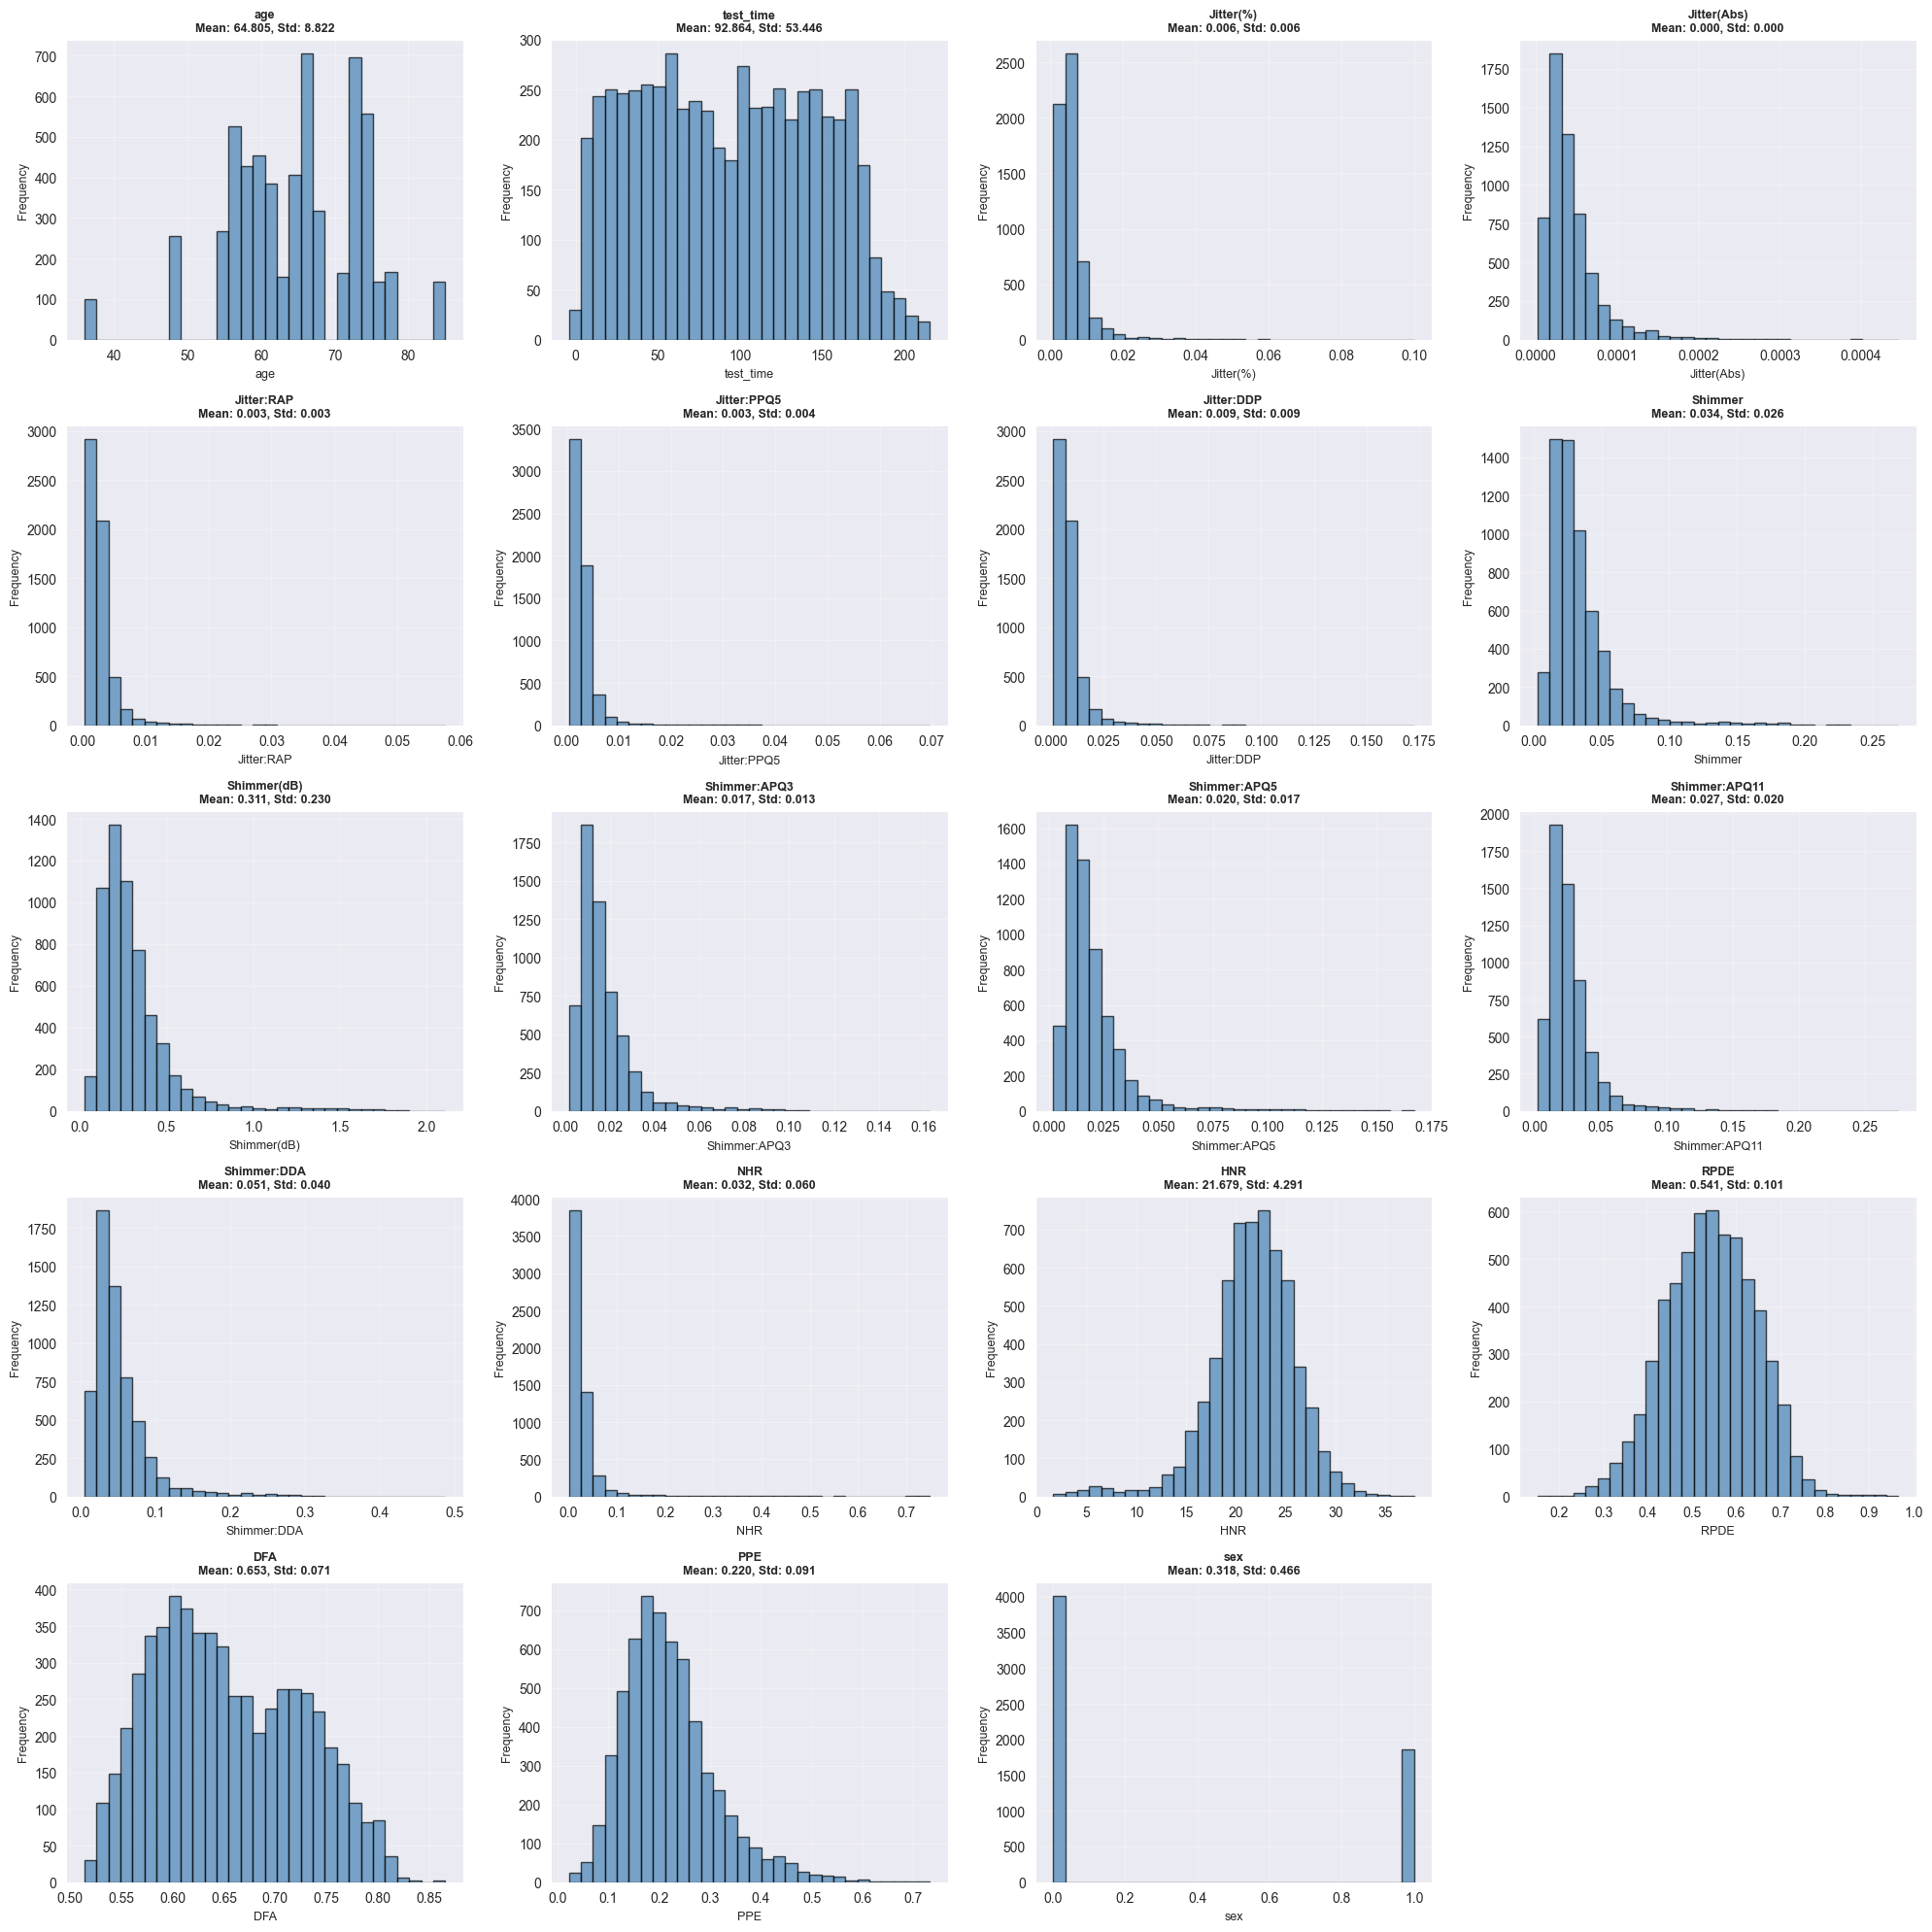


Distribution plots saved for 19 numerical variables


In [8]:
print("\n" + "="*80)
print("DISTRIBUTION ANALYSIS")
print("="*80)

# Get numerical columns
numerical_cols = pt_features.select_dtypes(include=[np.number]).columns.tolist()

# Plot distributions for all numerical variables
n_cols = len(numerical_cols)
n_rows = (n_cols + 3) // 4  # 4 plots per row
fig, axes = plt.subplots(n_rows, 4, figsize=(20, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes]

for idx, col in enumerate(numerical_cols):
    if idx < len(axes):
        axes[idx].hist(pt_features[col].dropna(), bins=30, color='steelblue', edgecolor='black', alpha=0.7)
        axes[idx].set_xlabel(col, fontsize=9)
        axes[idx].set_ylabel('Frequency', fontsize=9)
        axes[idx].set_title(f'{col}\nMean: {pt_features[col].mean():.3f}, Std: {pt_features[col].std():.3f}',
                           fontsize=9, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('distributions_all.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nDistribution plots saved for {len(numerical_cols)} numerical variables")

### Outlier Detection


OUTLIER DETECTION (Using IQR Method)

--- Variables with Outliers ---
       Column  Outlier_Count  Outlier_Percent  Lower_Bound  Upper_Bound
          NHR            436         7.421277    -0.019807     0.062225
  Jitter:PPQ5            425         7.234043    -0.000640     0.005920
   Jitter:RAP            414         7.046809    -0.000985     0.005855
   Jitter:DDP            413         7.029787    -0.002980     0.017580
    Jitter(%)            398         6.774468    -0.001250     0.011630
  Jitter(Abs)            366         6.229787    -0.000024     0.000100
      Shimmer            333         5.668085    -0.011825     0.070695
  Shimmer(dB)            332         5.651064    -0.110000     0.650000
 Shimmer:APQ3            332         5.651064    -0.007663     0.037518
  Shimmer:DDA            331         5.634043    -0.023027     0.112592
 Shimmer:APQ5            314         5.344681    -0.008658     0.043202
Shimmer:APQ11            314         5.344681    -0.009910     0.

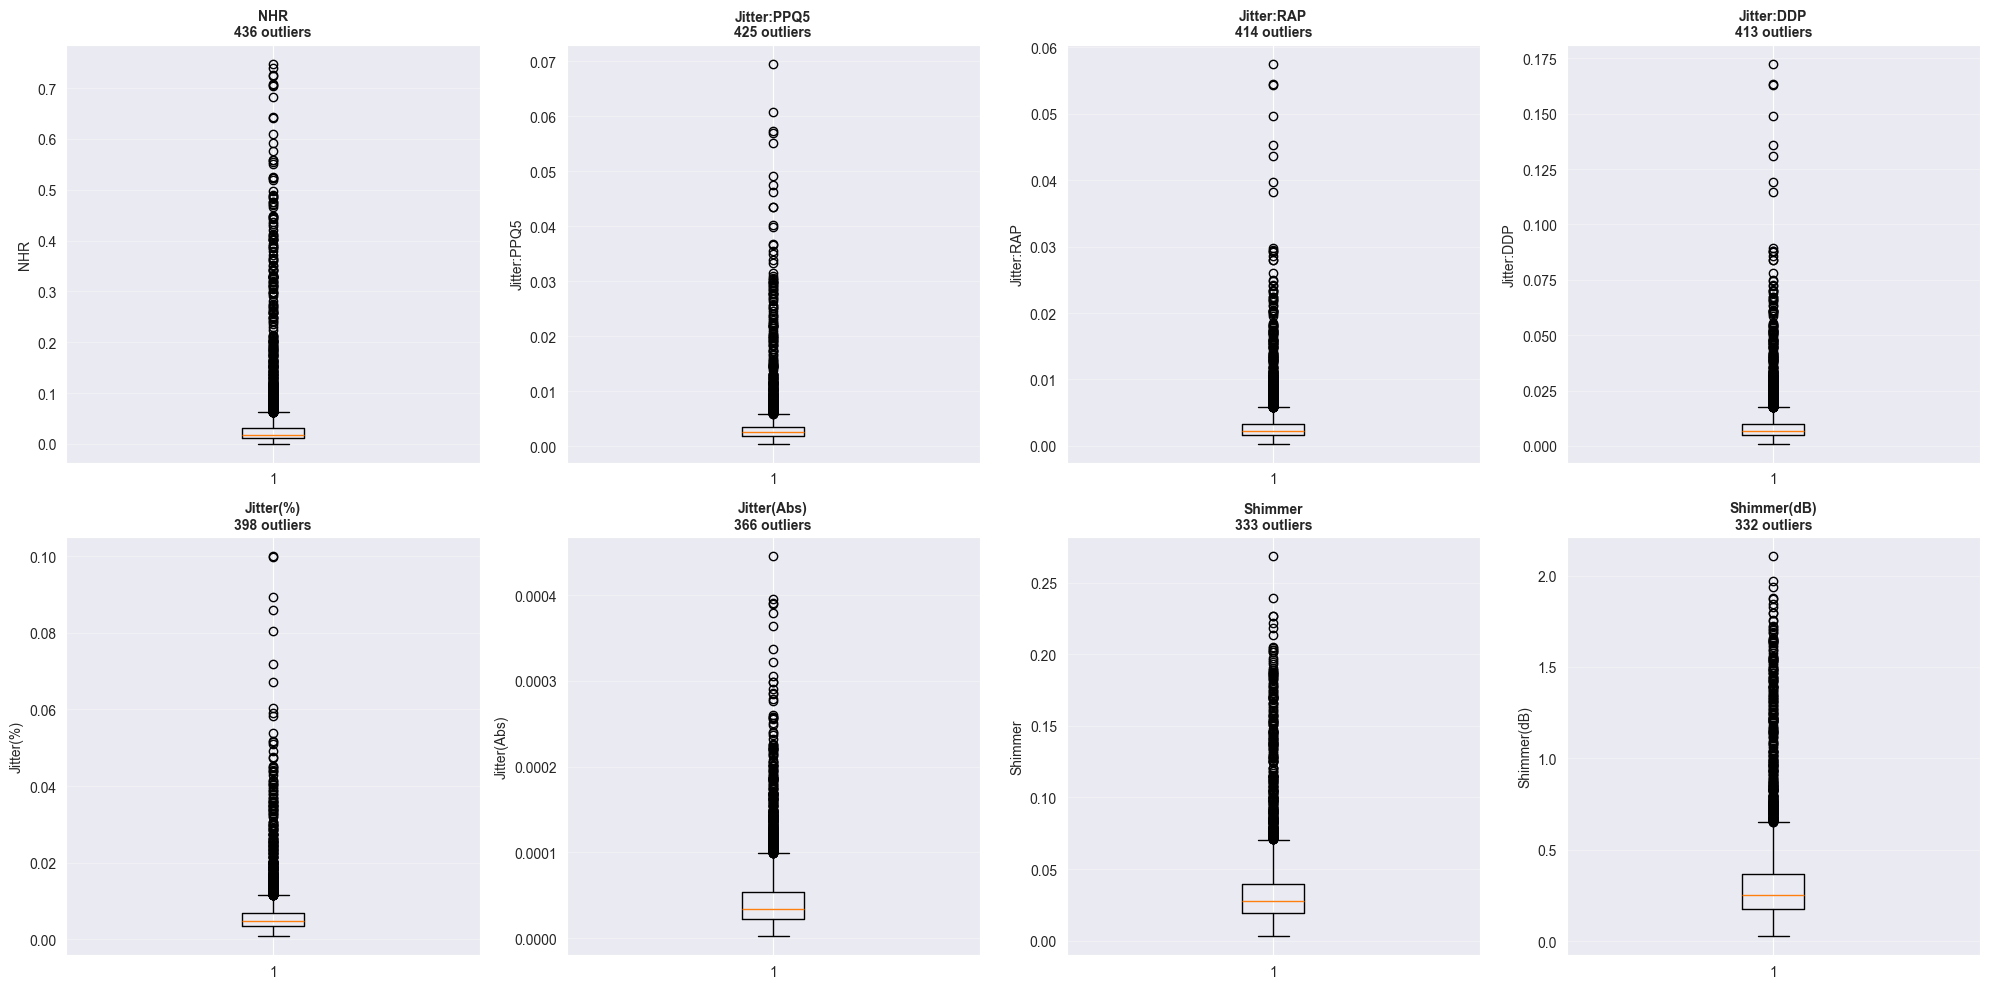

In [9]:
print("\n" + "="*80)
print("OUTLIER DETECTION (Using IQR Method)")
print("="*80)

outlier_summary = []

for col in numerical_cols:
    Q1 = pt_features[col].quantile(0.25)
    Q3 = pt_features[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = pt_features[(pt_features[col] < lower_bound) | (pt_features[col] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percent = (outlier_count / len(pt_features)) * 100

    outlier_summary.append({
        'Column': col,
        'Outlier_Count': outlier_count,
        'Outlier_Percent': outlier_percent,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df[outlier_df['Outlier_Count'] > 0].sort_values('Outlier_Count', ascending=False)

if len(outlier_df) > 0:
    print("\n--- Variables with Outliers ---")
    print(outlier_df.to_string(index=False))
else:
    print("\nNo outliers detected using IQR method")

# Box plots for variables with most outliers
if len(outlier_df) > 0:
    top_outlier_cols = outlier_df.head(8)['Column'].tolist()

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    for idx, col in enumerate(top_outlier_cols):
        if idx < len(axes):
            axes[idx].boxplot(pt_features[col].dropna(), vert=True)
            axes[idx].set_ylabel(col, fontsize=10)
            axes[idx].set_title(f'{col}\n{outlier_df[outlier_df["Column"]==col]["Outlier_Count"].values[0]} outliers',
                               fontsize=10, fontweight='bold')
            axes[idx].grid(True, alpha=0.3, axis='y')

    for idx in range(len(top_outlier_cols), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('outliers_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()


### Correlation Analysis


CORRELATION ANALYSIS

--- Highly Correlated Variable Pairs (|r| > 0.7) ---
   Variable_1    Variable_2  Correlation
 Shimmer:APQ3   Shimmer:DDA     1.000000
   Jitter:RAP    Jitter:DDP     1.000000
      Shimmer   Shimmer(dB)     0.992334
      Shimmer  Shimmer:APQ5     0.984904
    Jitter(%)    Jitter:DDP     0.984184
    Jitter(%)    Jitter:RAP     0.984181
      Shimmer  Shimmer:APQ3     0.979828
      Shimmer   Shimmer:DDA     0.979827
  Shimmer(dB)  Shimmer:APQ5     0.976373
    Jitter(%)   Jitter:PPQ5     0.968214
  Shimmer(dB)  Shimmer:APQ3     0.968015
  Shimmer(dB)   Shimmer:DDA     0.968014
 Shimmer:APQ5   Shimmer:DDA     0.962723
 Shimmer:APQ3  Shimmer:APQ5     0.962723
  Jitter:PPQ5    Jitter:DDP     0.947203
   Jitter:RAP   Jitter:PPQ5     0.947196
 Shimmer:APQ5 Shimmer:APQ11     0.938935
  Shimmer(dB) Shimmer:APQ11     0.936338
      Shimmer Shimmer:APQ11     0.935457
 Shimmer:APQ3 Shimmer:APQ11     0.885695
Shimmer:APQ11   Shimmer:DDA     0.885694
    Jitter(%)   Jitter

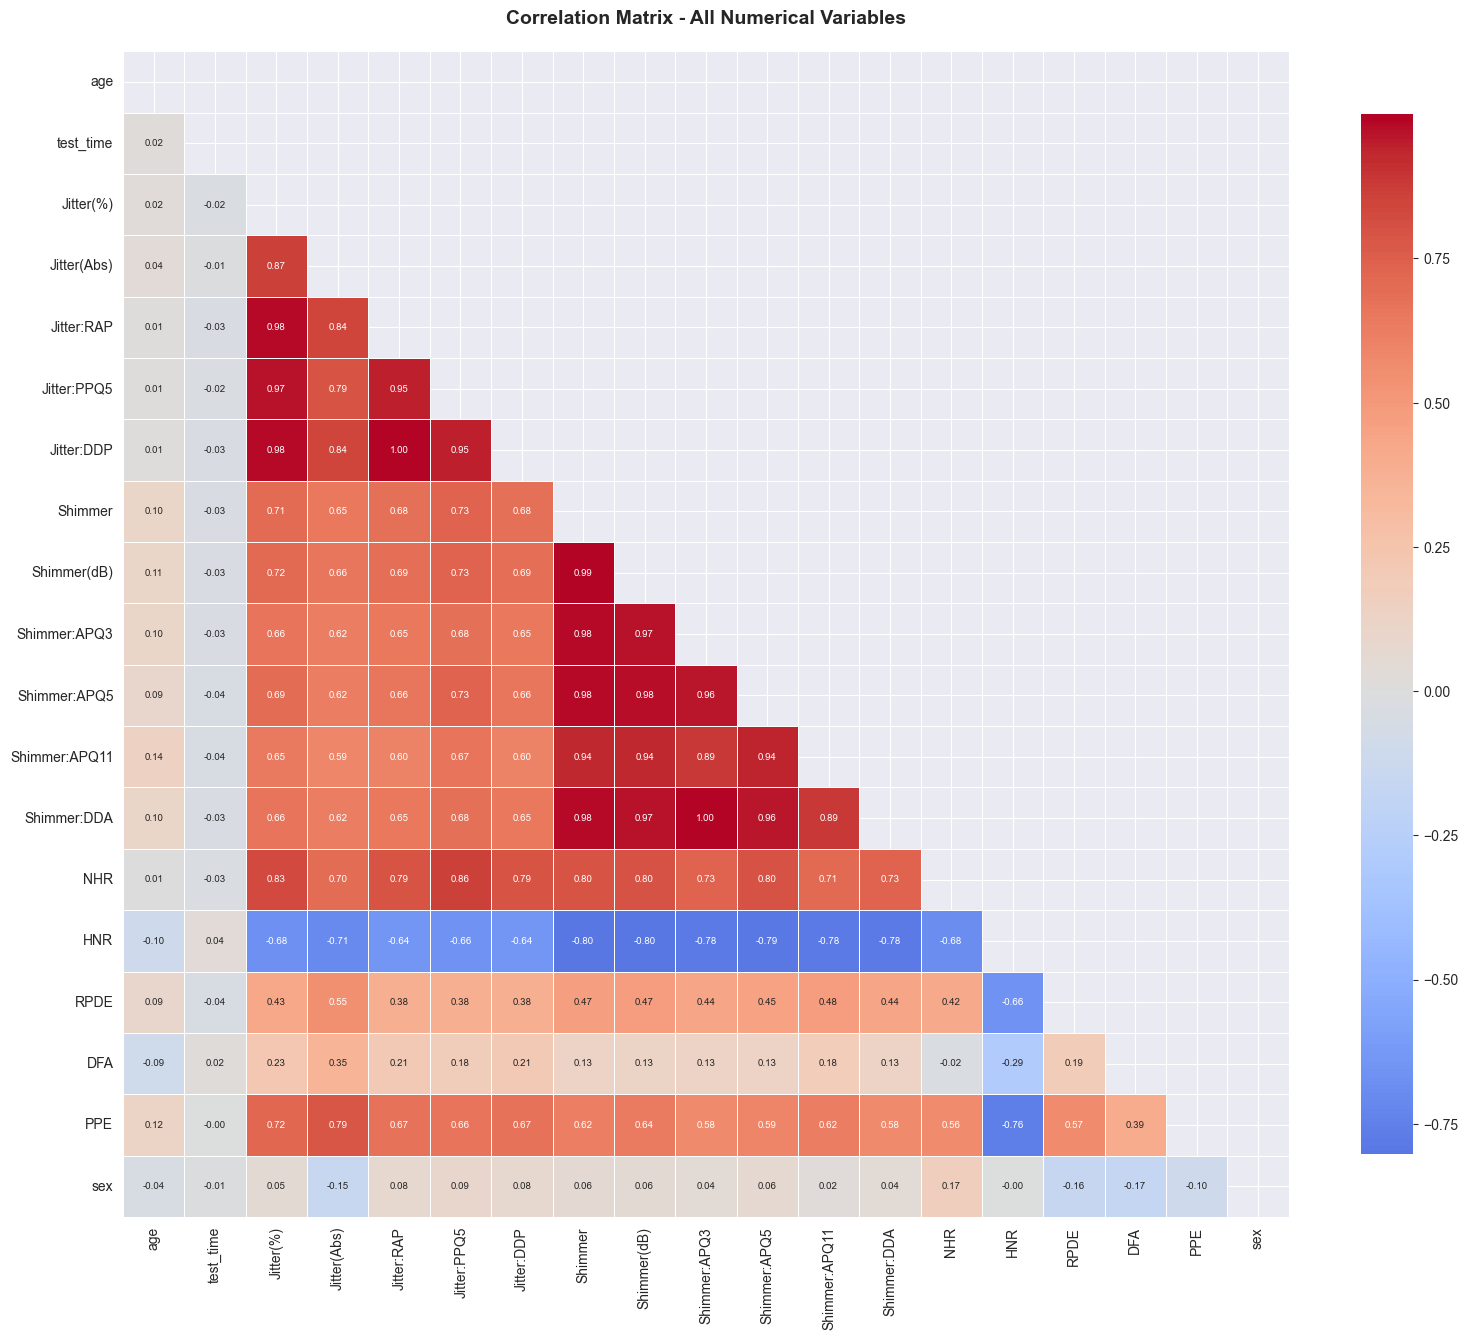

In [10]:
print("\n" + "="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Calculate correlation matrix
corr_matrix = pt_features[numerical_cols].corr()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:  # Threshold: 0.7
            high_corr_pairs.append({
                'Variable_1': corr_matrix.columns[i],
                'Variable_2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation',
                                                               key=abs,
                                                               ascending=False)
    print("\n--- Highly Correlated Variable Pairs (|r| > 0.7) ---")
    print(high_corr_df.to_string(index=False))
else:
    print("\n✓ No highly correlated pairs found (threshold: |r| > 0.7)")

# Correlation heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            annot_kws={'size': 7})
plt.title('Correlation Matrix - All Numerical Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap_full.png', dpi=300, bbox_inches='tight')
plt.show()


### Pairwise Relationships


PAIRWISE RELATIONSHIPS

Generating pairplot for variables: age, test_time, Jitter(%), Jitter(Abs), Jitter:RAP, Jitter:PPQ5


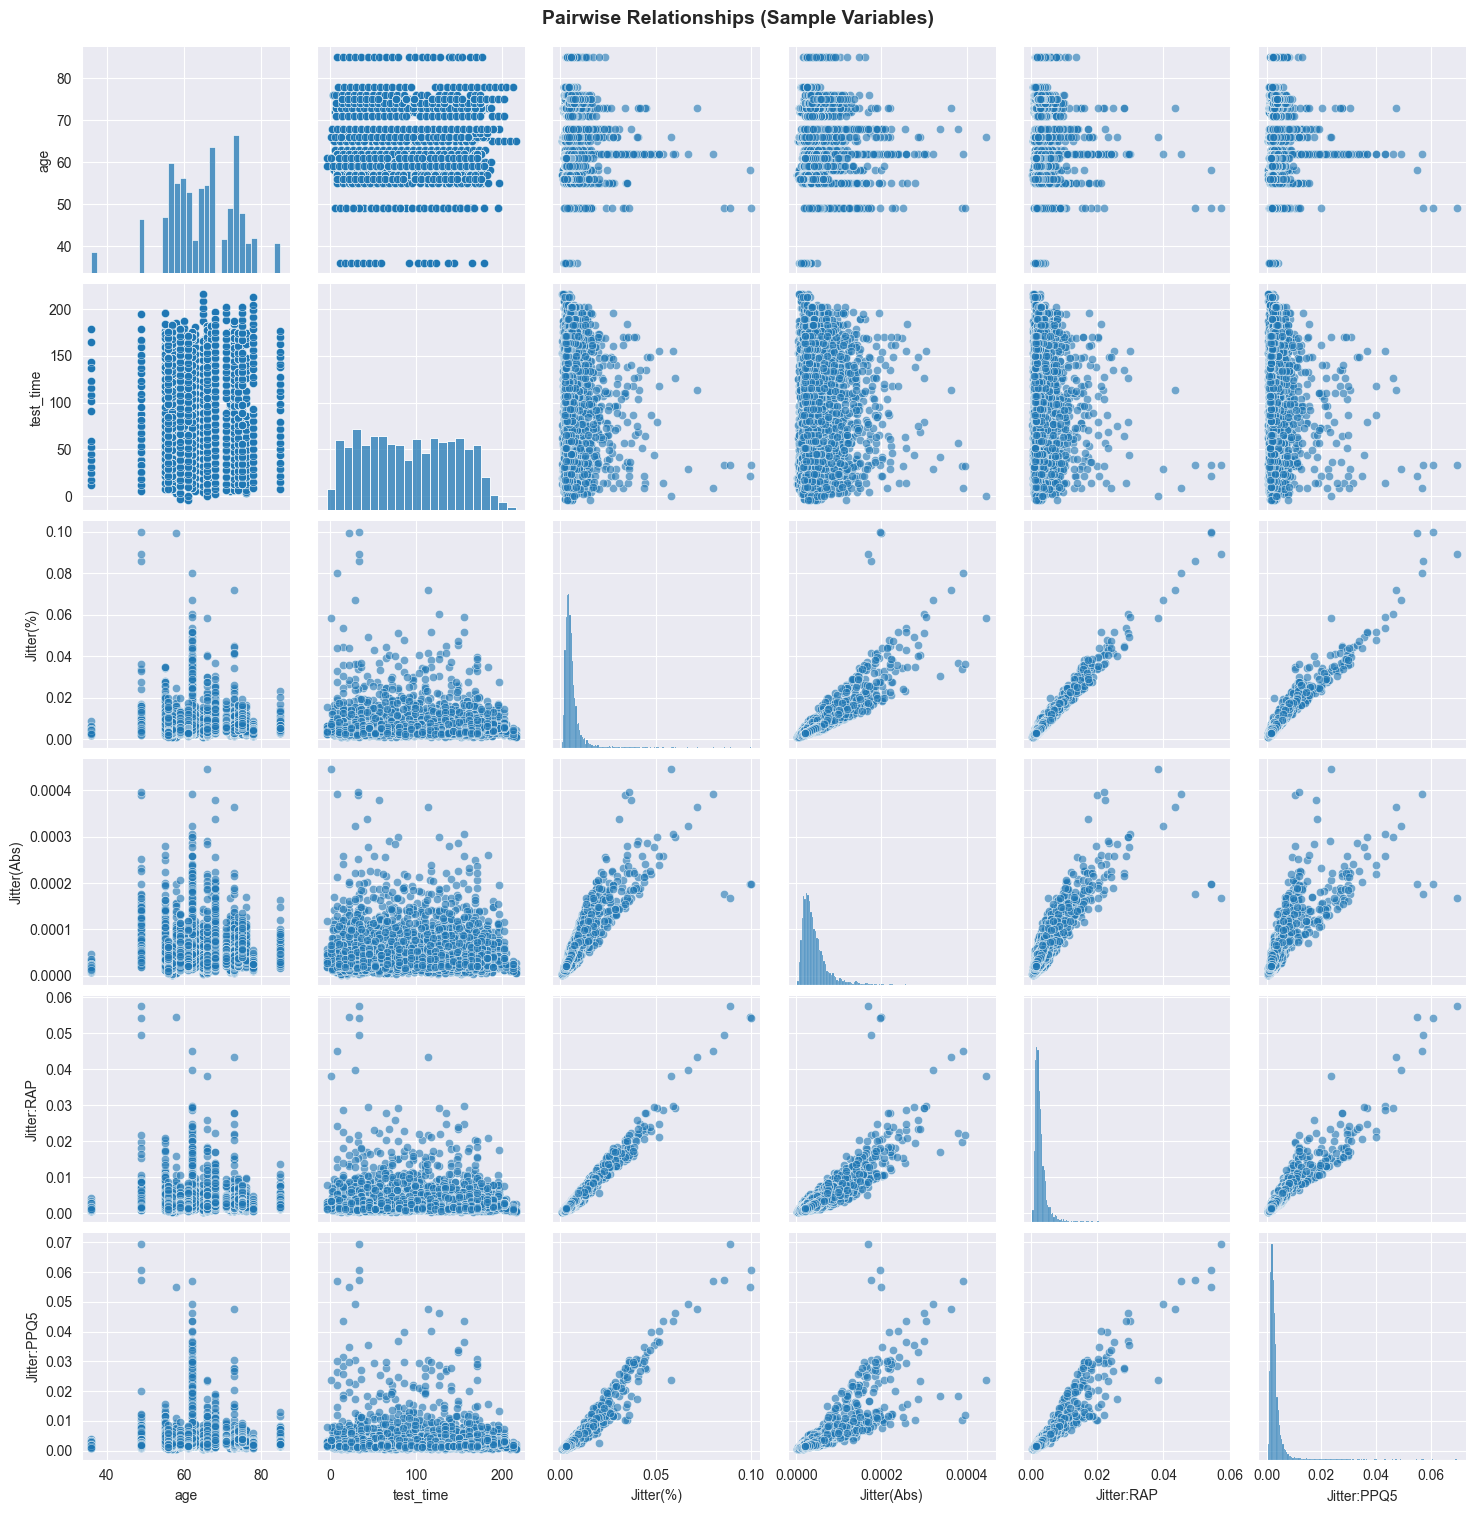

Pairplot generated for sample variables


In [11]:
print("\n" + "="*80)
print("PAIRWISE RELATIONSHIPS")
print("="*80)

# Select a subset of variables for pairplot (to avoid overcrowding)
# Choose first 6 numerical columns as example
sample_cols = numerical_cols[:6]

print(f"\nGenerating pairplot for variables: {', '.join(sample_cols)}")

pairplot_fig = sns.pairplot(pt_features[sample_cols], diag_kind='hist', plot_kws={'alpha': 0.6})
pairplot_fig.fig.suptitle('Pairwise Relationships (Sample Variables)',
                          y=1.01, fontsize=14, fontweight='bold')
plt.savefig('pairplot_sample.png', dpi=300, bbox_inches='tight')
plt.show()

print("Pairplot generated for sample variables")

### Skewness and Normality


SKEWNESS AND NORMALITY TESTS

--- Skewness and Normality Test Results ---
(Skewness: -0.5 to 0.5 = fairly symmetric, |s| > 1 = highly skewed)
       Column  Skewness  Kurtosis
          age -0.379133  0.670455
    test_time  0.077720 -1.147377
    Jitter(%)  6.451846 67.496559
  Jitter(Abs)  3.283006 18.155509
   Jitter:RAP  6.945438 78.534581
  Jitter:PPQ5  7.586205 81.566374
   Jitter:DDP  6.945376 78.532426
      Shimmer  3.312793 15.240156
  Shimmer(dB)  3.099221 13.091042
 Shimmer:APQ3  3.097223 14.724563
 Shimmer:APQ5  3.698061 19.244339
Shimmer:APQ11  3.406958 19.160187
  Shimmer:DDA  3.097224 14.724600
          NHR  6.549123 52.606172
          HNR -0.812057  2.505159
         RPDE -0.037434 -0.065036
          DFA  0.282078 -0.880246
          PPE  1.090819  1.951793
          sex  0.782873 -1.387582


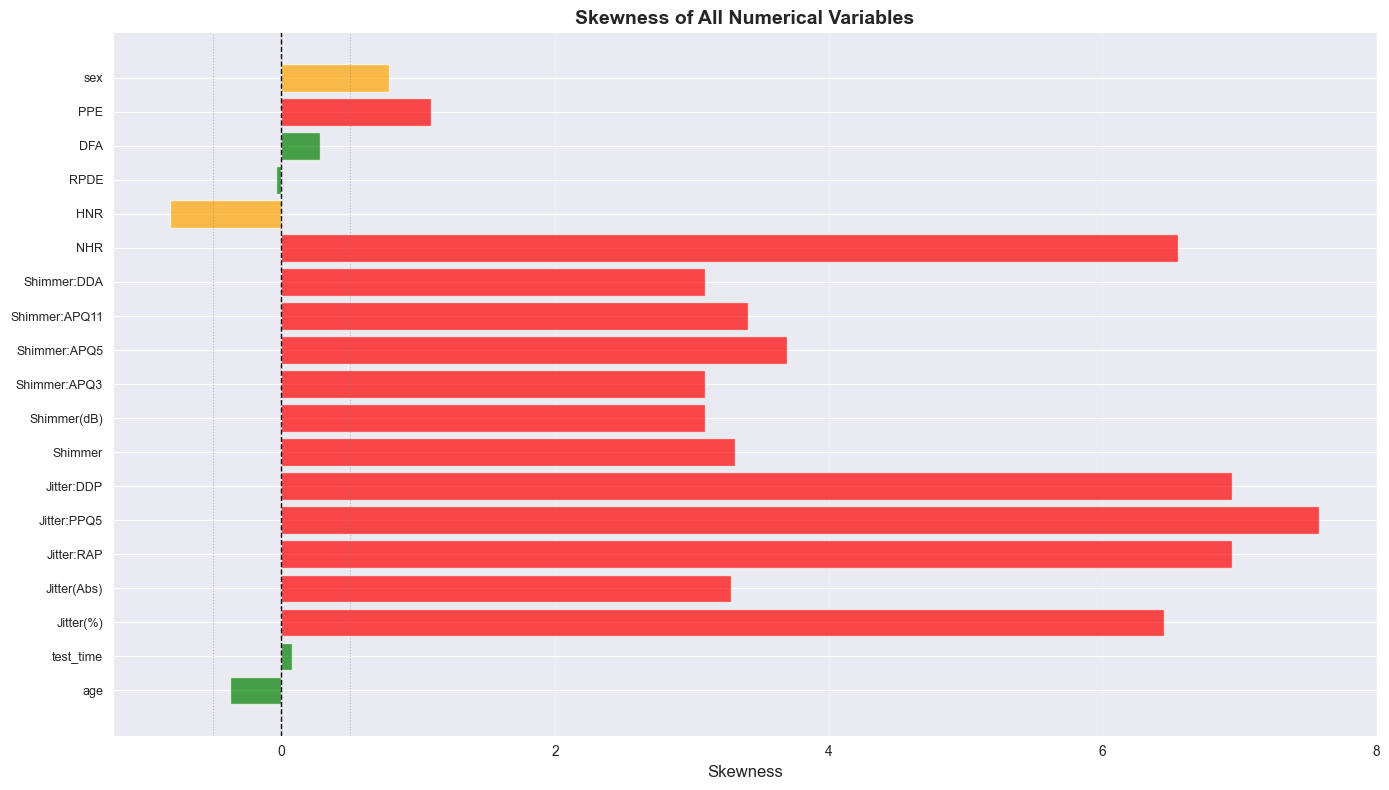

In [12]:
print("\n" + "="*80)
print("SKEWNESS AND NORMALITY TESTS")
print("="*80)

normality_results = []

for col in numerical_cols:
    skewness = pt_features[col].skew()
    kurtosis = pt_features[col].kurtosis()

    normality_results.append({
        'Column': col,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
    })

normality_df = pd.DataFrame(normality_results)

print("\n--- Skewness and Normality Test Results ---")
print("(Skewness: -0.5 to 0.5 = fairly symmetric, |s| > 1 = highly skewed)")
print(normality_df.to_string(index=False))

# Visualize skewness
fig, ax = plt.subplots(figsize=(14, 8))
colors = ['red' if abs(x) > 1 else 'orange' if abs(x) > 0.5 else 'green'
          for x in normality_df['Skewness']]
ax.barh(range(len(normality_df)), normality_df['Skewness'], color=colors, alpha=0.7)
ax.set_yticks(range(len(normality_df)))
ax.set_yticklabels(normality_df['Column'], fontsize=9)
ax.set_xlabel('Skewness', fontsize=12)
ax.set_title('Skewness of All Numerical Variables', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax.axvline(x=-0.5, color='gray', linestyle=':', linewidth=0.8, alpha=0.5)
ax.axvline(x=0.5, color='gray', linestyle=':', linewidth=0.8, alpha=0.5)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('skewness_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


### Summary Statistics by Groups

In [13]:
print("\n" + "="*80)
print("GROUPED ANALYSIS")
print("="*80)

if categorical_cols:
    for cat_col in categorical_cols[:3]:  # Analyze first 3 categorical variables
        print(f"\n--- Summary Statistics by {cat_col} ---")
        grouped = pt_features.groupby(cat_col)[numerical_cols[:5]].mean()  # First 5 numerical columns
        print(grouped)
else:
    print("\nNo categorical variables found for grouping analysis")



GROUPED ANALYSIS

--- Summary Statistics by sex ---
           age  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP
sex                                                          
0    65.055389  93.221349   0.005956     0.000048    0.002824
1    64.267274  92.095983   0.006577     0.000036    0.003338


### Data Quality

In [14]:
print("\n" + "="*80)
print("12. DATA QUALITY SUMMARY")
print("="*80)

print(f"\n{'Metric':<30s} {'Value':<20s}")
print("-" * 50)
print(f"{'Total Rows':<30s} {len(pt_features):<20,}")
print(f"{'Total Columns':<30s} {len(pt_features.columns):<20,}")
print(f"{'Numerical Columns':<30s} {len(numerical_cols):<20,}")
print(f"{'Categorical Columns':<30s} {len(categorical_cols):<20,}")
print(f"{'Total Missing Values':<30s} {pt_features.isnull().sum().sum():<20,}")
print(f"{'Missing Value %':<30s} {(pt_features.isnull().sum().sum() / (len(pt_features) * len(pt_features.columns)) * 100):<20.2f}%")
print(f"{'Duplicate Rows':<30s} {pt_features.duplicated().sum():<20,}")
print(f"{'Memory Usage':<30s} {pt_features.memory_usage(deep=True).sum() / 1024:.2f} KB")

# Check for duplicate rows
duplicates = pt_features.duplicated().sum()
if duplicates > 0:
    print(f"\n⚠ Warning: {duplicates} duplicate rows found")
    print("\nDuplicate rows:")
    print(pt_features[pt_features.duplicated(keep=False)].sort_values(by=list(pt_features.columns)))
else:
    print("\n✓ No duplicate rows found")


12. DATA QUALITY SUMMARY

Metric                         Value               
--------------------------------------------------
Total Rows                     5,875               
Total Columns                  19                  
Numerical Columns              19                  
Categorical Columns            1                   
Total Missing Values           0                   
Missing Value %                0.00                %
Duplicate Rows                 0                   
Memory Usage                   872.20 KB

✓ No duplicate rows found


### Key Insights

In [15]:
print("\n" + "="*80)
print("KEY INSIGHTS FROM EDA")
print("="*80)

print("\n--- Dataset Overview ---")
print(f"  • Dataset contains {len(pt_features):,} observations across {len(pt_features.columns)} variables")
print(f"  • {len(numerical_cols)} numerical and {len(categorical_cols)} categorical variables")

print("\n--- Data Quality ---")
if pt_features.isnull().sum().sum() == 0:
    print(" No missing values - dataset is complete")
else:
    print(f"{pt_features.isnull().sum().sum()} missing values found across {(pt_features.isnull().sum() > 0).sum()} columns")

if duplicates == 0:
    print("No duplicate rows")
else:
    print(f"  • {duplicates} duplicate rows detected")

print("\n--- Distribution Characteristics ---")
highly_skewed = normality_df[abs(normality_df['Skewness']) > 1]
if len(highly_skewed) > 0:
    print(f"  • {len(highly_skewed)} variables are highly skewed (|skewness| > 1):")
    for col in highly_skewed['Column'].tolist()[:5]:
        print(f"    - {col}")
else:
    print("  • No highly skewed variables detected")

print("\n--- Correlations ---")
if high_corr_pairs:
    print(f"  • {len(high_corr_pairs)} pairs of variables are highly correlated (|r| > 0.7)")
    for pair in high_corr_pairs[:3]:
        print(f"    - {pair['Variable_1']} ↔ {pair['Variable_2']}: r = {pair['Correlation']:.3f}")
else:
    print("  • No highly correlated variable pairs found")

print("\n--- Outliers ---")
if len(outlier_df) > 0:
    total_outliers = outlier_df['Outlier_Count'].sum()
    print(f"  • {total_outliers} outliers detected across {len(outlier_df)} variables")
    print(f"  • Variables with most outliers:")
    for idx, row in outlier_df.head(3).iterrows():
        print(f"    - {row['Column']}: {row['Outlier_Count']} ({row['Outlier_Percent']:.2f}%)")
else:
    print("  • No outliers detected using IQR method")


KEY INSIGHTS FROM EDA

--- Dataset Overview ---
  • Dataset contains 5,875 observations across 19 variables
  • 19 numerical and 1 categorical variables

--- Data Quality ---
 No missing values - dataset is complete
No duplicate rows

--- Distribution Characteristics ---
  • 13 variables are highly skewed (|skewness| > 1):
    - Jitter(%)
    - Jitter(Abs)
    - Jitter:RAP
    - Jitter:PPQ5
    - Jitter:DDP

--- Correlations ---
  • 50 pairs of variables are highly correlated (|r| > 0.7)
    - Jitter(%) ↔ Jitter(Abs): r = 0.866
    - Jitter(%) ↔ Jitter:RAP: r = 0.984
    - Jitter(%) ↔ Jitter:PPQ5: r = 0.968

--- Outliers ---
  • 4912 outliers detected across 16 variables
  • Variables with most outliers:
    - NHR: 436 (7.42%)
    - Jitter:PPQ5: 425 (7.23%)
    - Jitter:RAP: 414 (7.05%)


### Data Pre-Processing

In [16]:
print("="*80)
print("NEXT STEPS: DATA PREPROCESSING & MODELING PIPELINE")
print("="*80)

print("\n" + "="*80)
print("STEP 1: DATA PREPROCESSING")
print("="*80)


# Feature Categories for preprocessing
jitter_ft= ['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP']
shimmer_ft = ['Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
                    'Shimmer:APQ11', 'Shimmer:DDA']
noise_ft= ['NHR', 'HNR']
complexity_ft = ['RPDE', 'DFA', 'PPE']
demographic_ft = ['age', 'sex']

# Subsets
all_voice_ft = jitter_ft + shimmer_ft + noise_ft + complexity_ft

all_feat = all_voice_ft + demographic_ft

# Target vals
targets = ['motor_UPDRS', 'total_UPDRS']

print("\n --- : Handle Skewness with Transformations ---")
print("\n Applying Yeo-Johnson transformation to highly skewed features...")

# Copy of df for processing
pt_processed = pt_features.copy()

highly_skewed_ft = jitter_ft + shimmer_ft + ['NHR']

# Apply Yeo-Johnson Transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)

for feat in highly_skewed_ft:
    try:
        pt_processed[f'{feat}_transformed'] = pt.fit_transform(pt_processed[[feat]])
        print(f'Transformed {feat}: Skewness: {pt_features[feat].skew():.2f} -> {pt_processed[f'{feat}_transformed'].skew():.2f}')
    except:
        print(f'Could not transform {feat}')

NEXT STEPS: DATA PREPROCESSING & MODELING PIPELINE

STEP 1: DATA PREPROCESSING

 --- : Handle Skewness with Transformations ---

 Applying Yeo-Johnson transformation to highly skewed features...
Transformed Jitter(%): Skewness: 6.45 -> 0.32
Transformed Jitter(Abs): Skewness: 3.28 -> 0.25
Transformed Jitter:RAP: Skewness: 6.95 -> 0.38
Transformed Jitter:PPQ5: Skewness: 7.59 -> 0.42
Transformed Jitter:DDP: Skewness: 6.95 -> 0.38
Transformed Shimmer: Skewness: 3.31 -> 0.22
Transformed Shimmer(dB): Skewness: 3.10 -> 0.13
Transformed Shimmer:APQ3: Skewness: 3.10 -> 0.23
Transformed Shimmer:APQ5: Skewness: 3.70 -> 0.25
Transformed Shimmer:APQ11: Skewness: 3.41 -> 0.19
Transformed Shimmer:DDA: Skewness: 3.10 -> 0.21
Transformed NHR: Skewness: 6.55 -> 0.60


### Visualize Transformations

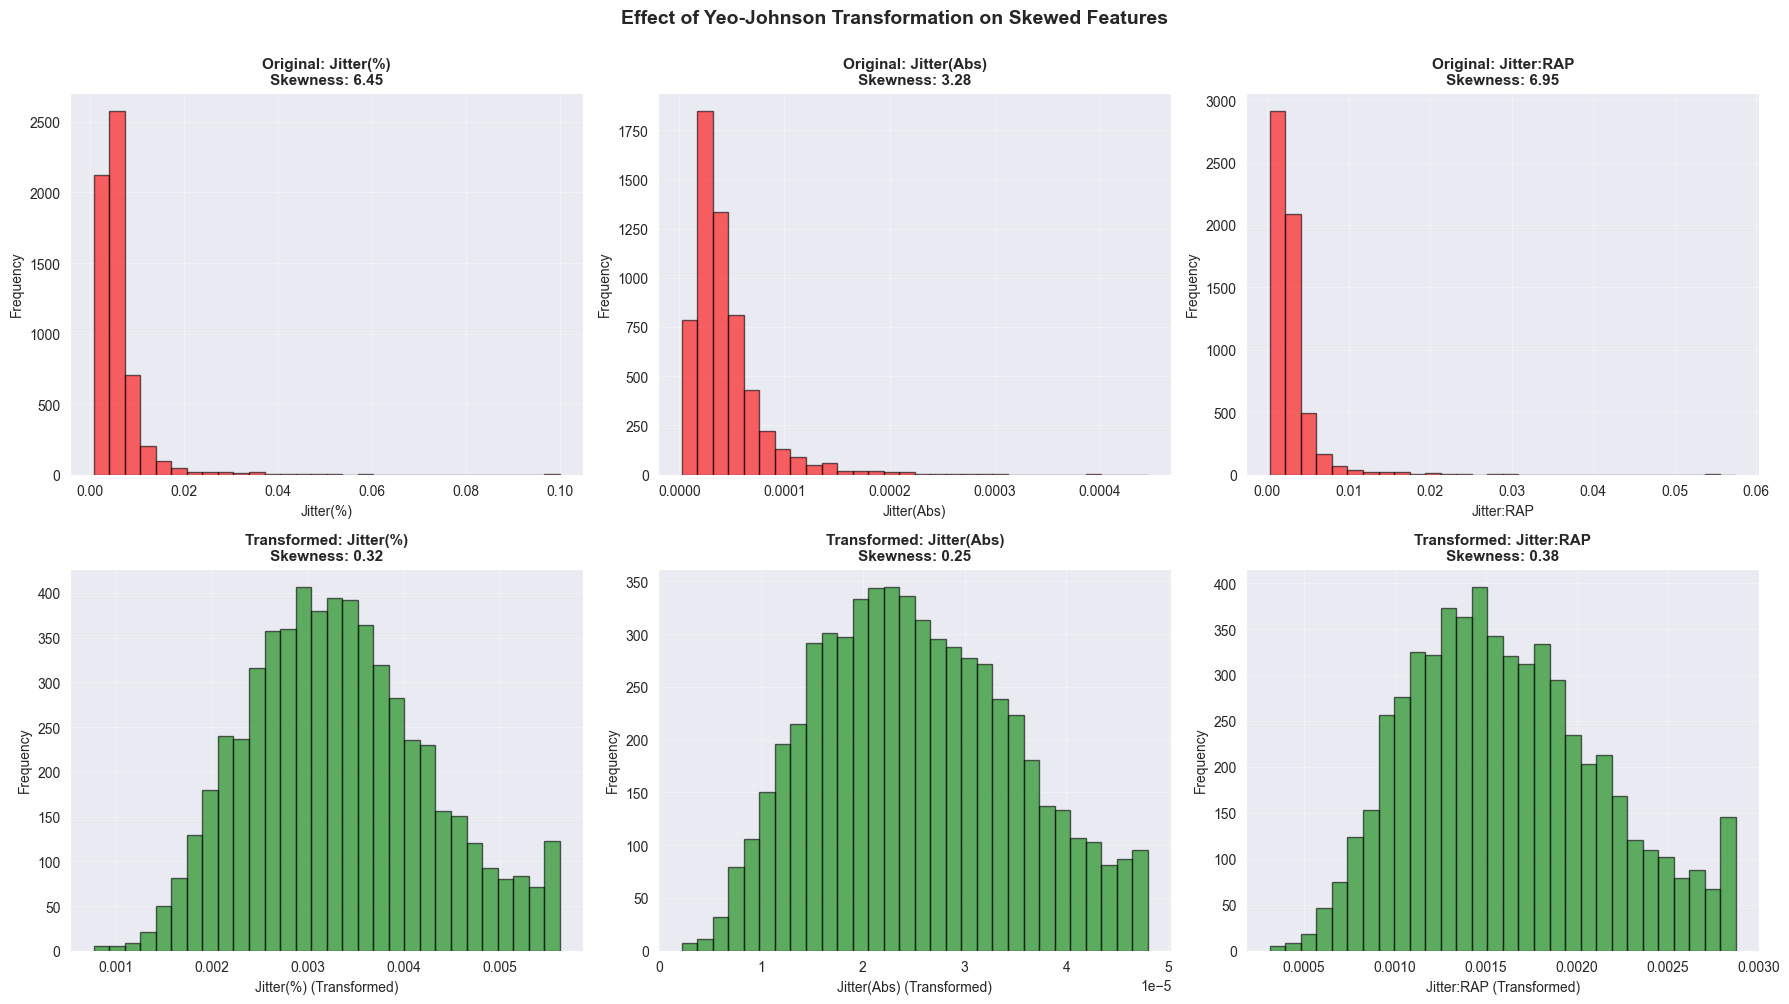

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

sample_features = highly_skewed_ft[:3]
for idx, feat in enumerate(sample_features):
    # Original
    axes[idx].hist(pt_features[feat], bins=30, color='red', alpha=0.6, edgecolor='black')
    axes[idx].set_xlabel(feat, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].set_title(f'Original: {feat}\nSkewness: {pt_features[feat].skew():.2f}',
                        fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

    # Transformed
    axes[idx+3].hist(pt_processed[f'{feat}_transformed'], bins=30, color='green',
                     alpha=0.6, edgecolor='black')
    axes[idx+3].set_xlabel(f'{feat} (Transformed)', fontsize=10)
    axes[idx+3].set_ylabel('Frequency', fontsize=10)
    axes[idx+3].set_title(f'Transformed: {feat}\nSkewness: {pt_processed[f"{feat}_transformed"].skew():.2f}',
                          fontsize=11, fontweight='bold')
    axes[idx+3].grid(True, alpha=0.3)

plt.suptitle('Effect of Yeo-Johnson Transformation on Skewed Features',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('transformation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Transformed and Non-Transformed Features

In [18]:
# Keep features that weren't transformed (HNR, complexity, demographics)
untransformed_features = ['HNR'] + complexity_ft + demographic_ft

# Combine transformed and untransformed features
final_features = [f'{f}_transformed' for f in highly_skewed_ft] + untransformed_features

# Check all features exist
final_features = [f for f in final_features if f in pt_processed.columns]

print(f"  • Total features for modeling: {len(final_features)}")
print(f"  • Transformed features: {len(highly_skewed)}")
print(f"  • Original features: {len(untransformed_features)}")


  • Total features for modeling: 18
  • Transformed features: 13
  • Original features: 6


### Feature Selection

In [19]:
print("\n" + "="*80)
print("FEATURE SELECTION (SIMPLIFIED)")
print("="*80)

print("\n--- Using Statistical Feature Selection (SelectKBest) ---")

# Prepare feature matrix
X = pt_processed[final_features].copy()
y_motor = pt_target['motor_UPDRS']
y_total = pt_target['total_UPDRS']

# Handle any NaN values
X = X.fillna(X.median())

# Select top K features based on F-statistic
K = 10  # Select top 10 features
selector = SelectKBest(score_func=f_regression, k=K)
selector.fit(X, y_motor)

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': final_features,
    'F_Score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values('F_Score', ascending=False)

print(f"\nTop {K} Features Selected (based on F-statistic with Motor UPDRS):")
print("\n" + feature_scores.head(K).to_string(index=False))

# Get selected feature names
selected_features = feature_scores.head(K)['Feature'].tolist()


FEATURE SELECTION (SIMPLIFIED)

--- Using Statistical Feature Selection (SelectKBest) ---

Top 10 Features Selected (based on F-statistic with Motor UPDRS):

                  Feature    F_Score       p_value
                      age 475.450718 2.008637e-101
Shimmer:APQ11_transformed 167.042690  1.065234e-37
                      PPE 159.155223  5.058273e-36
                      HNR 148.477437  9.505684e-34
  Shimmer(dB)_transformed 117.811782  3.449350e-27
          NHR_transformed 110.583507  1.232127e-25
      Shimmer_transformed 108.394343  3.643451e-25
    Jitter(%)_transformed 106.219944  1.070159e-24
  Jitter:PPQ5_transformed 100.661806  1.685567e-23
                     RPDE  98.772297  4.306902e-23


### Visualize Features

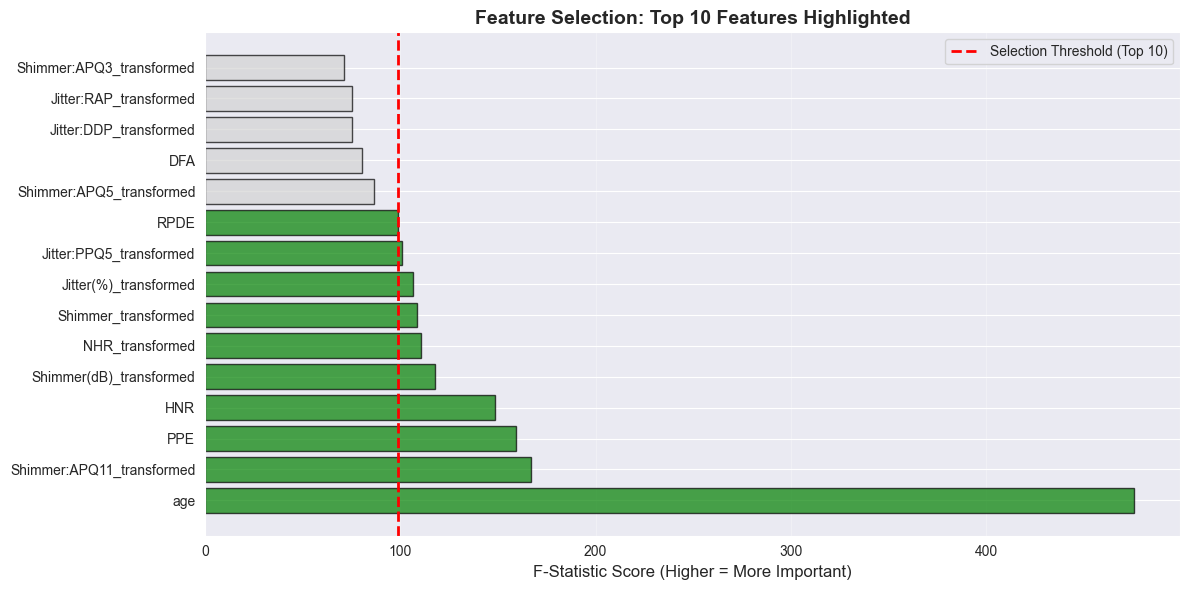


✓ Feature selection complete: 18 → 10 features


In [20]:
# Visualize feature selection
plt.figure(figsize=(12, 6))
top_features = feature_scores.head(15)
colors = ['green' if i < K else 'lightgray' for i in range(len(top_features))]
plt.barh(range(len(top_features)), top_features['F_Score'], color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=10)
plt.xlabel('F-Statistic Score (Higher = More Important)', fontsize=12)
plt.title(f'Feature Selection: Top {K} Features Highlighted', fontsize=14, fontweight='bold')
plt.axvline(x=top_features.iloc[K-1]['F_Score'], color='red', linestyle='--',
            linewidth=2, label=f'Selection Threshold (Top {K})')
plt.legend()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_selection.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Feature selection complete: {len(final_features)} → {K} features")

### Data Modeling Preparation

In [21]:
print("\n" + "="*80)
print("STEP 3: PREPARE DATA FOR MODELING")
print("="*80)

# Use selected features
X_selected = X[selected_features].copy()

# Apply RobustScaler (final scaling)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_selected)
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_features)

print(f"\n✓ Data prepared for modeling:")
print(f"  • Feature matrix shape: {X_scaled_df.shape}")
print(f"  • Target: Motor UPDRS (mean: {y_motor.mean():.2f}, std: {y_motor.std():.2f})")
print(f"  • Scaling method: RobustScaler (outlier-resistant)")


STEP 3: PREPARE DATA FOR MODELING

✓ Data prepared for modeling:
  • Feature matrix shape: (5875, 10)
  • Target: Motor UPDRS (mean: 21.30, std: 8.13)
  • Scaling method: RobustScaler (outlier-resistant)


In [22]:
print("\n" + "="*80)
print("STEP 4: REGRESSION MODELS")
print("="*80)

# Setup cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
print("\nUsing 5-Fold Cross-Validation")

# Dictionary to store results
model_results = []

print("\n--- Linear Regression (Baseline) ---")
lr_model = LinearRegression()
lr_scores = cross_val_score(lr_model, X_scaled, y_motor, cv=cv,
                             scoring='neg_mean_squared_error')
lr_rmse = np.sqrt(-lr_scores.mean())
lr_std = np.sqrt(-lr_scores).std()

print(f"Linear Regression:")
print(f"  RMSE: {lr_rmse:.3f} (± {lr_std:.3f})")
print(f"  Description: Ordinary least squares, no regularization")

model_results.append({
    'Model': 'Linear Regression',
    'RMSE': lr_rmse,
    'Std': lr_std,
    'Description': 'Baseline OLS'
})


STEP 4: REGRESSION MODELS

Using 5-Fold Cross-Validation

--- Linear Regression (Baseline) ---
Linear Regression:
  RMSE: 7.712 (± 0.177)
  Description: Ordinary least squares, no regularization


In [23]:
print("\n--- Ridge Regression (L2 Regularization) ---")
# Test multiple alpha values
alphas = [0.1, 1.0, 10.0, 100.0]
best_ridge_rmse = float('inf')
best_alpha = None

print("Testing Ridge with different regularization strengths (alpha):")
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_scores = cross_val_score(ridge_model, X_scaled, y_motor, cv=cv,
                                    scoring='neg_mean_squared_error')
    ridge_rmse = np.sqrt(-ridge_scores.mean())
    print(f"  • Alpha={alpha:6.1f}: RMSE = {ridge_rmse:.3f}")

    if ridge_rmse < best_ridge_rmse:
        best_ridge_rmse = ridge_rmse
        best_alpha = alpha
        best_ridge_std = np.sqrt(-ridge_scores).std()

print(f"\nBest Ridge Regression (alpha={best_alpha}):")
print(f"  • RMSE: {best_ridge_rmse:.3f} (± {best_ridge_std:.3f})")
print(f"  • Description: L2 regularization, handles multicollinearity")

model_results.append({
    'Model': f'Ridge (α={best_alpha})',
    'RMSE': best_ridge_rmse,
    'Std': best_ridge_std,
    'Description': 'L2 regularization'
})


--- Ridge Regression (L2 Regularization) ---
Testing Ridge with different regularization strengths (alpha):
  • Alpha=   0.1: RMSE = 7.712
  • Alpha=   1.0: RMSE = 7.712
  • Alpha=  10.0: RMSE = 7.712
  • Alpha= 100.0: RMSE = 7.719

Best Ridge Regression (alpha=1.0):
  • RMSE: 7.712 (± 0.177)
  • Description: L2 regularization, handles multicollinearity


In [24]:
print("\n Lasso Regression (L1 Regularization) ")
# Test multiple alpha values
alphas = [0.01, 0.1, 1.0, 10.0]
best_lasso_rmse = float('inf')
best_lasso_alpha = None

print("Testing Lasso with different regularization strengths (alpha):")
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, max_iter=10000)
    lasso_scores = cross_val_score(lasso_model, X_scaled, y_motor, cv=cv,
                                    scoring='neg_mean_squared_error')
    lasso_rmse = np.sqrt(-lasso_scores.mean())
    print(f"  • Alpha={alpha:6.2f}: RMSE = {lasso_rmse:.3f}")

    if lasso_rmse < best_lasso_rmse:
        best_lasso_rmse = lasso_rmse
        best_lasso_alpha = alpha
        best_lasso_std = np.sqrt(-lasso_scores).std()

print(f"\nBest Lasso Regression (alpha={best_lasso_alpha}):")
print(f"  • RMSE: {best_lasso_rmse:.3f} (± {best_lasso_std:.3f})")
print(f"  • Description: L1 regularization, automatic feature selection")

model_results.append({
    'Model': f'Lasso (α={best_lasso_alpha})',
    'RMSE': best_lasso_rmse,
    'Std': best_lasso_std,
    'Description': 'L1 regularization'
})


 Lasso Regression (L1 Regularization) 
Testing Lasso with different regularization strengths (alpha):
  • Alpha=  0.01: RMSE = 7.711
  • Alpha=  0.10: RMSE = 7.747
  • Alpha=  1.00: RMSE = 7.972
  • Alpha= 10.00: RMSE = 8.129

Best Lasso Regression (alpha=0.01):
  • RMSE: 7.711 (± 0.176)
  • Description: L1 regularization, automatic feature selection


In [25]:
print(" ElasticNet Regression (L1 + L2 Regularization)")
# Test multiple alpha values
alphas = [0.01, 0.1, 1.0, 10.0]
best_elastic_rmse = float('inf')
best_elastic_alpha = None

print("Testing ElasticNet with different regularization strengths (alpha):")
for alpha in alphas:
    elastic_model = ElasticNet(alpha=alpha, l1_ratio=0.5, max_iter=10000)
    elastic_scores = cross_val_score(elastic_model, X_scaled, y_motor, cv=cv,
                                     scoring='neg_mean_squared_error')
    elastic_rmse = np.sqrt(-elastic_scores.mean())
    print(f"  • Alpha={alpha:6.2f}: RMSE = {elastic_rmse:.3f}")

    if elastic_rmse < best_elastic_rmse:
        best_elastic_rmse = elastic_rmse
        best_elastic_alpha = alpha
        best_elastic_std = np.sqrt(-elastic_scores).std()

print(f"\nBest ElasticNet (alpha={best_elastic_alpha}, l1_ratio=0.5):")
print(f"  • RMSE: {best_elastic_rmse:.3f} (± {best_elastic_std:.3f})")
print(f"  • Description: Combined L1+L2, balances feature selection and stability")

model_results.append({
    'Model': f'ElasticNet (α={best_elastic_alpha})',
    'RMSE': best_elastic_rmse,
    'Std': best_elastic_std,
    'Description': 'L1+L2 combined'
})

 ElasticNet Regression (L1 + L2 Regularization)
Testing ElasticNet with different regularization strengths (alpha):
  • Alpha=  0.01: RMSE = 7.713
  • Alpha=  0.10: RMSE = 7.746
  • Alpha=  1.00: RMSE = 7.919
  • Alpha= 10.00: RMSE = 8.129

Best ElasticNet (alpha=0.01, l1_ratio=0.5):
  • RMSE: 7.713 (± 0.176)
  • Description: Combined L1+L2, balances feature selection and stability


### Model Comparison


STEP 5: MODEL COMPARISON & RESULTS

Final Model Performance (sorted by RMSE):

              Model     RMSE      Std       Description
     Lasso (α=0.01) 7.711098 0.176116 L1 regularization
      Ridge (α=1.0) 7.711667 0.176743 L2 regularization
  Linear Regression 7.711748 0.176666      Baseline OLS
ElasticNet (α=0.01) 7.712941 0.175992    L1+L2 combined

🏆 BEST MODEL: Lasso (α=0.01)
   RMSE: 7.711


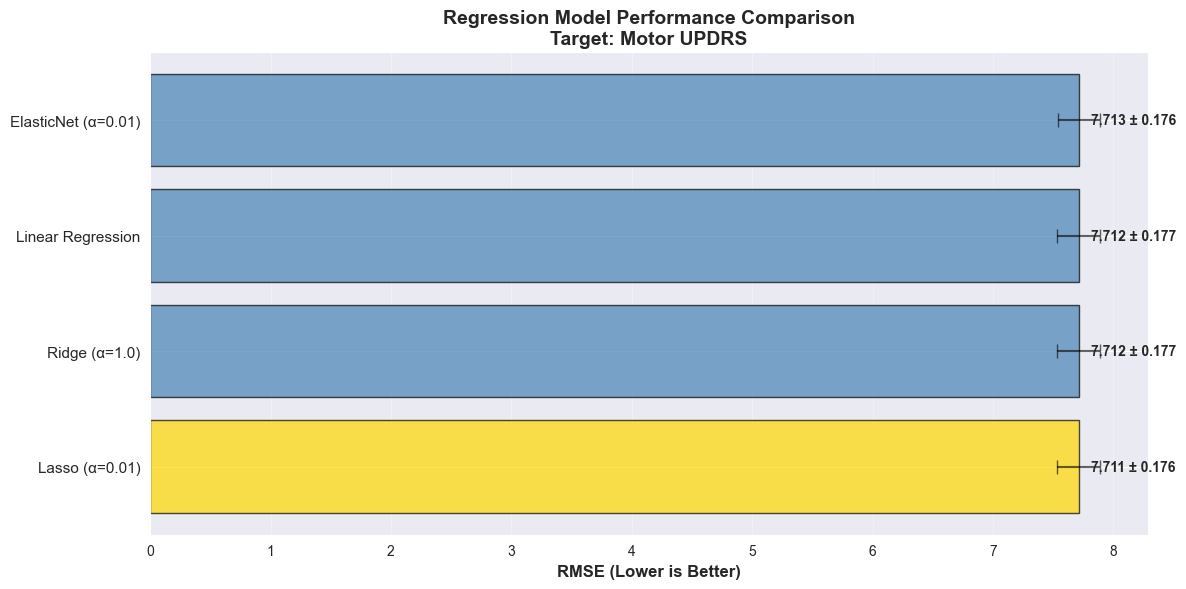

In [26]:
print("\n" + "="*80)
print("STEP 5: MODEL COMPARISON & RESULTS")
print("="*80)

# Create results dataframe
results_df = pd.DataFrame(model_results).sort_values('RMSE')

print("\nFinal Model Performance (sorted by RMSE):")
print("\n" + results_df.to_string(index=False))

# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_rmse = results_df.iloc[0]['RMSE']

print(f"\n BEST MODEL: {best_model_name}")
print(f"   RMSE: {best_rmse:.3f}")

# Visualize model comparison
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = range(len(results_df))
colors = ['gold' if i == 0 else 'steelblue' for i in range(len(results_df))]

bars = ax.barh(x_pos, results_df['RMSE'], color=colors, alpha=0.7, edgecolor='black')
ax.errorbar(results_df['RMSE'], x_pos, xerr=results_df['Std'],
            fmt='none', ecolor='black', capsize=5, alpha=0.6)

ax.set_yticks(x_pos)
ax.set_yticklabels(results_df['Model'], fontsize=11)
ax.set_xlabel('RMSE (Lower is Better)', fontsize=12, fontweight='bold')
ax.set_title('Regression Model Performance Comparison\nTarget: Motor UPDRS',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for i, (rmse, std) in enumerate(zip(results_df['RMSE'], results_df['Std'])):
    ax.text(rmse + 0.1, i, f'{rmse:.3f} ± {std:.3f}',
            va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


### Feature Analysis from Best Model


STEP 6: FEATURE IMPORTANCE ANALYSIS

Feature Importance (from Lasso (α=0.01)):

                  Feature  Coefficient
      Shimmer_transformed    -3.449617
                      age     3.320387
Shimmer:APQ11_transformed     2.784494
                      HNR    -1.321276
                      PPE     0.998229
  Jitter:PPQ5_transformed    -0.734255
          NHR_transformed     0.127511
                     RPDE     0.083701
  Shimmer(dB)_transformed     0.000000
    Jitter(%)_transformed     0.000000


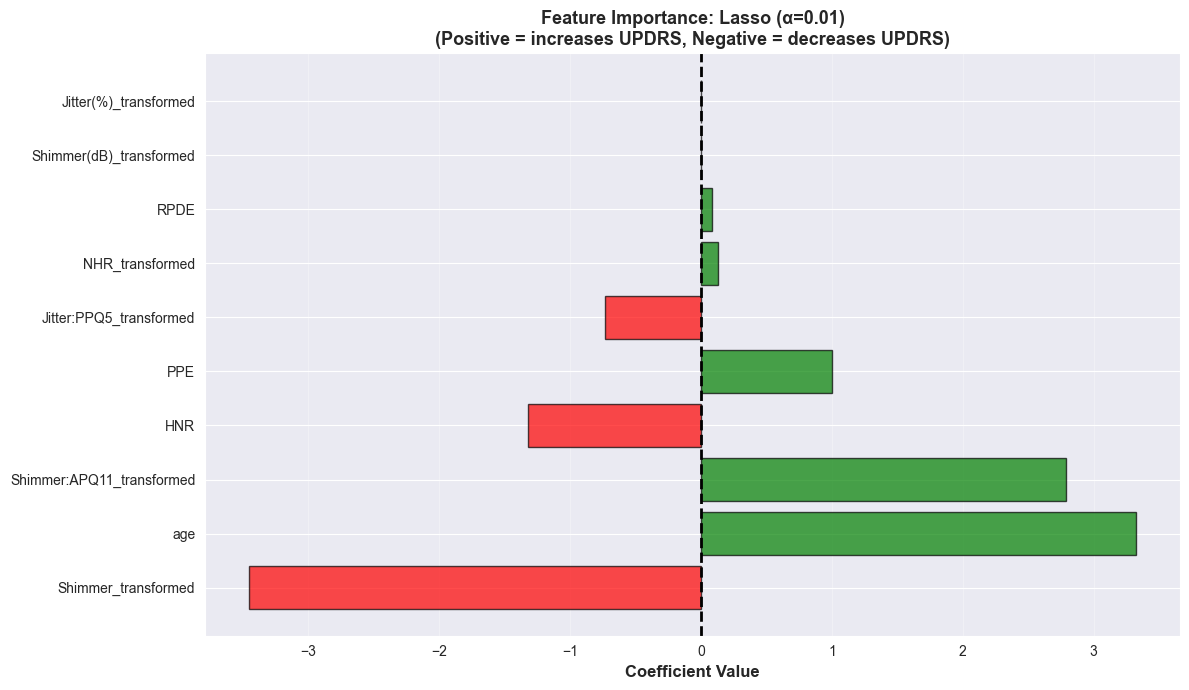

In [27]:
print("\n" + "="*80)
print("STEP 6: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Train best model on full data to get coefficients
if 'Ridge' in best_model_name:
    final_model = Ridge(alpha=best_alpha)
elif 'Lasso' in best_model_name:
    final_model = Lasso(alpha=best_lasso_alpha, max_iter=10000)
elif 'ElasticNet' in best_model_name:
    final_model = ElasticNet(alpha=best_elastic_alpha, l1_ratio=0.5, max_iter=10000)
else:
    final_model = LinearRegression()

final_model.fit(X_scaled, y_motor)

# Get coefficients
coefficients = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': final_model.coef_,
    'Abs_Coefficient': np.abs(final_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\nFeature Importance (from {best_model_name}):")
print("\n" + coefficients[['Feature', 'Coefficient']].to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 7))

colors = ['red' if x < 0 else 'green' for x in coefficients['Coefficient']]
ax.barh(range(len(coefficients)), coefficients['Coefficient'],
        color=colors, alpha=0.7, edgecolor='black')

ax.set_yticks(range(len(coefficients)))
ax.set_yticklabels(coefficients['Feature'], fontsize=10)
ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_title(f'Feature Importance: {best_model_name}\n(Positive = increases UPDRS, Negative = decreases UPDRS)',
             fontsize=13, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

### Summary

In [28]:
print("\n" + "="*80)
print("STEP 7: SUMMARY & RECOMMENDATIONS")
print("="*80)

print(f"""
PIPELINE SUMMARY:
================

1. PREPROCESSING:
    Transformed {len(highly_skewed)} highly skewed features (Yeo-Johnson)
    Applied RobustScaler (outlier-resistant)
    Reduced skewness from 6-8 to <1

2. FEATURE SELECTION:
    Selected top {K} features using F-statistic
    Reduced from {len(final_features)} to {K} features
    Data-driven selection based on statistical significance

3. REGRESSION MODELS TESTED:
    Linear Regression (baseline)
    Ridge Regression (L2 regularization)
    Lasso Regression (L1 regularization)
    ElasticNet (L1 + L2 combined)

4. BEST MODEL:
   {best_model_name}
   RMSE: {best_rmse:.3f}

5. KEY FINDINGS:
   Top 3 most important features:
     1. {coefficients.iloc[0]['Feature']} (coef: {coefficients.iloc[0]['Coefficient']:.3f})
     2. {coefficients.iloc[1]['Feature']} (coef: {coefficients.iloc[1]['Coefficient']:.3f})
     3. {coefficients.iloc[2]['Feature']} (coef: {coefficients.iloc[2]['Coefficient']:.3f})

RECOMMENDATIONS:
================
• Use {best_model_name} for predicting Motor UPDRS
• Focus on top 5 features for clinical interpretation
• Consider testing on Total UPDRS as well
• Validate on held-out test set before deployment
""")

print("="*80)
print("ANALYSIS COMPLETE")
print("="*80)


STEP 7: SUMMARY & RECOMMENDATIONS

PIPELINE SUMMARY:

1. PREPROCESSING:
    Transformed 13 highly skewed features (Yeo-Johnson)
    Applied RobustScaler (outlier-resistant)
    Reduced skewness from 6-8 to <1

2. FEATURE SELECTION:
    Selected top 10 features using F-statistic
    Reduced from 18 to 10 features
    Data-driven selection based on statistical significance

3. REGRESSION MODELS TESTED:
    Linear Regression (baseline)
    Ridge Regression (L2 regularization)
    Lasso Regression (L1 regularization)
    ElasticNet (L1 + L2 combined)

4. BEST MODEL:
   Lasso (α=0.01)
   RMSE: 7.711

5. KEY FINDINGS:
   Top 3 most important features:
     1. Shimmer_transformed (coef: -3.450)
     2. age (coef: 3.320)
     3. Shimmer:APQ11_transformed (coef: 2.784)

RECOMMENDATIONS:
• Use Lasso (α=0.01) for predicting Motor UPDRS
• Focus on top 5 features for clinical interpretation
• Consider testing on Total UPDRS as well
• Validate on held-out test set before deployment

ANALYSIS COMPLE